In [31]:
import collections

import datasets
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torchtext
import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split

In [32]:
print(torch.__version__)
print(torch.backends.cudnn.version())
print(torchvision.__version__)
print(torchtext.__version__)

2.0.0+cu118
8700
0.15.1+cu118
0.15.1


In [33]:
class LSTM(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        n_layers,
        bidirectional,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            n_layers,
            bidirectional=bidirectional,
            dropout=dropout_rate,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids, length):
        # ids = [batch size, seq len]
        # length = [batch size]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        # output = [batch size, seq len, hidden dim * n directions]
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
            # hidden = [batch size, hidden dim * 2]
        else:
            hidden = self.dropout(hidden[-1])
            # hidden = [batch size, hidden dim]
        prediction = self.fc(hidden)
        # prediction = [batch size, output dim]
        return prediction

In [34]:
 predictionseed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
# # 加载IMDB数据集
# train_data = datasets.load_dataset("imdb", split="train")
# test_data = datasets.load_dataset("imdb", split="test")
# 
# test_size = 0.25
# train_valid_data = train_data.train_test_split(test_size=test_size)
# train_data = train_valid_data["train"]
# valid_data = train_valid_data["test"]

In [37]:
# 加载citation_sentiment_corpus数据集
df = pd.read_csv(f"./data/citation_sentiment_corpus_new.csv")

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['Citation_Text'].tolist(), df['Sentiment'].tolist(), test_size=0.25, stratify=df['Sentiment'], random_state=42)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

train_data = Dataset.from_dict({'text': train_texts, 'label': train_labels})
valid_data = Dataset.from_dict({'text': val_texts, 'label': val_labels})
test_data = Dataset.from_dict({'text': test_texts, 'label': test_labels})
emotion_data = DatasetDict({'train': train_data, 'valid': valid_data, 'test': test_data})

In [38]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

def tokenize_example(example, tokenizer, max_length):
    tokens = tokenizer(example["text"])[:max_length]
    length = len(tokens)
    return {"tokens": tokens, "length": length}

In [39]:
max_length = 256

train_data = train_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
test_data = test_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
valid_data = valid_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

Map:   0%|          | 0/6524 [00:00<?, ? examples/s]

Map:   0%|          | 0/1088 [00:00<?, ? examples/s]

Map:   0%|          | 0/1087 [00:00<?, ? examples/s]

In [40]:
min_freq = 5
special_tokens = ["<unk>", "<pad>"]

# 根据数据集的文本构建词汇表
vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)
print(f"vocab size: {len(vocab)}")

vocab size: 3687


In [41]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]
vocab.set_default_index(unk_index)

In [42]:
def numericalize_example(example, vocab):
    # 构建词汇表找到对应词汇的索引
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

In [43]:
train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

Map:   0%|          | 0/6524 [00:00<?, ? examples/s]

Map:   0%|          | 0/1087 [00:00<?, ? examples/s]

Map:   0%|          | 0/1088 [00:00<?, ? examples/s]

In [44]:
train_data = train_data.with_format(type="torch", columns=["ids", "label", "length"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label", "length"])
test_data = test_data.with_format(type="torch", columns=["ids", "label", "length"])

In [45]:
train_data[0]

{'label': tensor(0),
 'length': tensor(96),
 'ids': tensor([  27,  153,    6,  312,  669,  121,  727,    7,  147, 1273,    0,   53,
          537,  544,   11, 2144,   66,  304,    7,    0,    5,  188,   57,    2,
           46,    0,    2, 1192,    7, 2183,  107,    2,  422,    2, 2183,    2,
            7, 3184,   44,    2, 1016,    9,    8,    3,   44,    4,    2,    7,
           11,    0, 2590,   10,   69,  373,    5,    0,    9,    8,    3, 1817,
            2,    0,  168,    0,   44,    2,    0,    9,    8,    3,   44,    2,
         2133,   40,    2,    0,  107,    2, 1106,  168,    0,  661,    2,    0,
            9,    8,    3,   94,    2, 3184,    9,    8,    3,   18,    4,    3])}

In [46]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_length = [i["length"] for i in batch]
        batch_length = torch.stack(batch_length)
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "length": batch_length, "label": batch_label}
        return batch

    return collate_fn

In [47]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [48]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [49]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = len(train_data.unique("label"))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_index,
)

In [50]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 4,717,503 trainable parameters


In [51]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

In [52]:
model.apply(initialize_weights)

LSTM(
  (embedding): Embedding(3687, 300, padding_idx=1)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=600, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [53]:
vectors = torchtext.vocab.GloVe()
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
model.embedding.weight.data = pretrained_embedding

In [54]:
lr = 5e-4
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

In [55]:
def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    epoch_precisions = []
    epoch_recalls = []
    epoch_f1s = []
    for batch in tqdm.tqdm(dataloader, desc="training..."):
        ids = batch["ids"].to(device)
        length = batch["length"]
        label = batch["label"].to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        precision = get_precision(prediction, label)
        recall = get_recall(prediction, label)
        f1 = get_f1(precision, recall)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
        epoch_precisions.append(precision)
        epoch_recalls.append(recall)
        epoch_f1s.append(f1)
    return np.mean(epoch_losses), np.mean(epoch_accs), np.mean(epoch_precisions), np.mean(epoch_recalls), np.mean(epoch_f1s)

In [56]:
def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    epoch_precisions = []
    epoch_recalls = []
    epoch_f1s = []
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            label = batch["label"].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            precision = get_precision(prediction, label)
            recall = get_recall(prediction, label)
            f1 = get_f1(precision, recall)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
            epoch_precisions.append(precision)
            epoch_recalls.append(recall)
            epoch_f1s.append(f1)
    return np.mean(epoch_losses), np.mean(epoch_accs), np.mean(epoch_precisions), np.mean(epoch_recalls), np.mean(epoch_f1s)


def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

def get_precision(prediction, label):
    predicted_classes = prediction.argmax(dim=-1)
    true_positive = (predicted_classes & label).sum().item()
    false_positive = (predicted_classes & ~label).sum().item()
    precision = true_positive / (true_positive + false_positive + 1e-10)
    return precision

def get_recall(prediction, label):
    predicted_classes = prediction.argmax(dim=-1)
    true_positive = (predicted_classes & label).sum().item()
    false_negative = (~predicted_classes & label).sum().item()
    recall = true_positive / (true_positive + false_negative + 1e-10)
    return recall

def get_f1(precision, recall):
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    return f1

In [57]:
n_epochs = 35
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc, train_precision, train_recall, train_f1 = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc, valid_precision, valid_recall, valid_f1 = evaluate(
        valid_data_loader, model, criterion, device
    )
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["train_precisions"].append(train_precision)
    metrics["train_recalls"].append(train_recall)
    metrics["train_f1s"].append(train_f1)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    metrics["valid_precisions"].append(valid_precision)
    metrics["valid_recalls"].append(valid_recall)
    metrics["valid_f1s"].append(valid_f1)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "lstm.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}, train_precision: {train_precision:.3f}, train_recall: {train_recall:.3f}, train_f1: {train_f1:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}, valid_precision: {valid_precision:.3f}, valid_recall: {valid_recall:.3f}, valid_f1: {valid_f1:.3f}")

evaluating...: 100%|██████████| 3/3 [00:00<00:00, 36.82it/s]


epoch: 0
train_loss: 0.622, train_acc: 0.829, train_precision: 0.007, train_recall: 0.037, train_f1: 0.012
valid_loss: 0.458, valid_acc: 0.868, valid_precision: 0.000, valid_recall: 0.000, valid_f1: 0.000


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 40.80it/s]


epoch: 1
train_loss: 0.463, train_acc: 0.873, train_precision: 0.000, train_recall: 0.000, train_f1: 0.000
valid_loss: 0.458, valid_acc: 0.868, valid_precision: 0.000, valid_recall: 0.000, valid_f1: 0.000


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 40.92it/s]


epoch: 2
train_loss: 0.451, train_acc: 0.872, train_precision: 0.000, train_recall: 0.000, train_f1: 0.000
valid_loss: 0.437, valid_acc: 0.868, valid_precision: 0.000, valid_recall: 0.000, valid_f1: 0.000


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 34.11it/s]


epoch: 3
train_loss: 0.437, train_acc: 0.873, train_precision: 0.000, train_recall: 0.000, train_f1: 0.000
valid_loss: 0.429, valid_acc: 0.868, valid_precision: 0.000, valid_recall: 0.000, valid_f1: 0.000


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 33.75it/s]


epoch: 4
train_loss: 0.430, train_acc: 0.873, train_precision: 0.000, train_recall: 0.000, train_f1: 0.000
valid_loss: 0.412, valid_acc: 0.868, valid_precision: 0.000, valid_recall: 0.000, valid_f1: 0.000


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 33.56it/s]


epoch: 5
train_loss: 0.407, train_acc: 0.874, train_precision: 0.280, train_recall: 0.016, train_f1: 0.030
valid_loss: 0.385, valid_acc: 0.865, valid_precision: 0.095, valid_recall: 0.007, valid_f1: 0.013


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 28.80it/s]


epoch: 6
train_loss: 0.376, train_acc: 0.875, train_precision: 0.469, train_recall: 0.083, train_f1: 0.139
valid_loss: 0.390, valid_acc: 0.867, valid_precision: 0.251, valid_recall: 0.024, valid_f1: 0.043


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 44.06it/s]


epoch: 7
train_loss: 0.362, train_acc: 0.878, train_precision: 0.513, train_recall: 0.100, train_f1: 0.165
valid_loss: 0.374, valid_acc: 0.870, valid_precision: 0.344, valid_recall: 0.062, valid_f1: 0.104


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 42.59it/s]


epoch: 8
train_loss: 0.344, train_acc: 0.880, train_precision: 0.550, train_recall: 0.154, train_f1: 0.228
valid_loss: 0.365, valid_acc: 0.861, valid_precision: 0.288, valid_recall: 0.077, valid_f1: 0.122


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 41.91it/s]


epoch: 9
train_loss: 0.324, train_acc: 0.888, train_precision: 0.601, train_recall: 0.175, train_f1: 0.264
valid_loss: 0.366, valid_acc: 0.869, valid_precision: 0.392, valid_recall: 0.138, valid_f1: 0.204


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 42.47it/s]


epoch: 10
train_loss: 0.319, train_acc: 0.890, train_precision: 0.598, train_recall: 0.197, train_f1: 0.281
valid_loss: 0.358, valid_acc: 0.876, valid_precision: 0.566, valid_recall: 0.155, valid_f1: 0.243


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 43.14it/s]


epoch: 11
train_loss: 0.305, train_acc: 0.893, train_precision: 0.628, train_recall: 0.217, train_f1: 0.314
valid_loss: 0.418, valid_acc: 0.871, valid_precision: 0.393, valid_recall: 0.081, valid_f1: 0.134


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 40.90it/s]


epoch: 12
train_loss: 0.289, train_acc: 0.897, train_precision: 0.617, train_recall: 0.247, train_f1: 0.343
valid_loss: 0.352, valid_acc: 0.869, valid_precision: 0.462, valid_recall: 0.284, valid_f1: 0.350


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 42.49it/s]


epoch: 13
train_loss: 0.268, train_acc: 0.907, train_precision: 0.662, train_recall: 0.342, train_f1: 0.445
valid_loss: 0.369, valid_acc: 0.887, valid_precision: 0.577, valid_recall: 0.259, valid_f1: 0.349


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 41.23it/s]


epoch: 14
train_loss: 0.254, train_acc: 0.907, train_precision: 0.632, train_recall: 0.348, train_f1: 0.444
valid_loss: 0.386, valid_acc: 0.874, valid_precision: 0.473, valid_recall: 0.278, valid_f1: 0.341


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 41.52it/s]


epoch: 15
train_loss: 0.232, train_acc: 0.916, train_precision: 0.662, train_recall: 0.420, train_f1: 0.512
valid_loss: 0.379, valid_acc: 0.878, valid_precision: 0.504, valid_recall: 0.264, valid_f1: 0.339


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 39.38it/s]


epoch: 16
train_loss: 0.220, train_acc: 0.918, train_precision: 0.671, train_recall: 0.453, train_f1: 0.539
valid_loss: 0.399, valid_acc: 0.872, valid_precision: 0.474, valid_recall: 0.290, valid_f1: 0.353


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 42.03it/s]


epoch: 17
train_loss: 0.212, train_acc: 0.921, train_precision: 0.681, train_recall: 0.481, train_f1: 0.558
valid_loss: 0.462, valid_acc: 0.884, valid_precision: 0.573, valid_recall: 0.291, valid_f1: 0.377


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 35.59it/s]


epoch: 18
train_loss: 0.201, train_acc: 0.930, train_precision: 0.753, train_recall: 0.504, train_f1: 0.601
valid_loss: 0.398, valid_acc: 0.878, valid_precision: 0.524, valid_recall: 0.306, valid_f1: 0.383


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 38.08it/s]


epoch: 19
train_loss: 0.189, train_acc: 0.929, train_precision: 0.729, train_recall: 0.555, train_f1: 0.628
valid_loss: 0.439, valid_acc: 0.884, valid_precision: 0.568, valid_recall: 0.336, valid_f1: 0.422


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 40.29it/s]


epoch: 20
train_loss: 0.175, train_acc: 0.933, train_precision: 0.731, train_recall: 0.585, train_f1: 0.646
valid_loss: 0.430, valid_acc: 0.882, valid_precision: 0.522, valid_recall: 0.270, valid_f1: 0.354


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 43.42it/s]


epoch: 21
train_loss: 0.176, train_acc: 0.935, train_precision: 0.740, train_recall: 0.589, train_f1: 0.653
valid_loss: 0.458, valid_acc: 0.880, valid_precision: 0.520, valid_recall: 0.325, valid_f1: 0.399


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 38.57it/s]


epoch: 22
train_loss: 0.160, train_acc: 0.941, train_precision: 0.778, train_recall: 0.648, train_f1: 0.702
valid_loss: 0.417, valid_acc: 0.886, valid_precision: 0.550, valid_recall: 0.388, valid_f1: 0.454


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 43.54it/s]


epoch: 23
train_loss: 0.153, train_acc: 0.940, train_precision: 0.752, train_recall: 0.644, train_f1: 0.693
valid_loss: 0.419, valid_acc: 0.883, valid_precision: 0.539, valid_recall: 0.374, valid_f1: 0.439


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 42.02it/s]


epoch: 24
train_loss: 0.136, train_acc: 0.949, train_precision: 0.799, train_recall: 0.705, train_f1: 0.746
valid_loss: 0.472, valid_acc: 0.875, valid_precision: 0.464, valid_recall: 0.251, valid_f1: 0.325


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 40.36it/s]


epoch: 25
train_loss: 0.134, train_acc: 0.947, train_precision: 0.785, train_recall: 0.682, train_f1: 0.727
valid_loss: 0.466, valid_acc: 0.880, valid_precision: 0.528, valid_recall: 0.329, valid_f1: 0.404


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 42.18it/s]


epoch: 26
train_loss: 0.124, train_acc: 0.955, train_precision: 0.812, train_recall: 0.745, train_f1: 0.775
valid_loss: 0.478, valid_acc: 0.884, valid_precision: 0.530, valid_recall: 0.365, valid_f1: 0.429


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 42.00it/s]


epoch: 27
train_loss: 0.119, train_acc: 0.955, train_precision: 0.814, train_recall: 0.737, train_f1: 0.770
valid_loss: 0.474, valid_acc: 0.887, valid_precision: 0.563, valid_recall: 0.366, valid_f1: 0.439


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 41.45it/s]


epoch: 28
train_loss: 0.116, train_acc: 0.957, train_precision: 0.833, train_recall: 0.745, train_f1: 0.784
valid_loss: 0.478, valid_acc: 0.885, valid_precision: 0.562, valid_recall: 0.375, valid_f1: 0.446


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 43.02it/s]


epoch: 29
train_loss: 0.105, train_acc: 0.961, train_precision: 0.848, train_recall: 0.783, train_f1: 0.811
valid_loss: 0.489, valid_acc: 0.884, valid_precision: 0.534, valid_recall: 0.365, valid_f1: 0.431


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 42.55it/s]


epoch: 30
train_loss: 0.102, train_acc: 0.960, train_precision: 0.831, train_recall: 0.783, train_f1: 0.804
valid_loss: 0.538, valid_acc: 0.873, valid_precision: 0.511, valid_recall: 0.316, valid_f1: 0.385


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 36.14it/s]


epoch: 31
train_loss: 0.105, train_acc: 0.961, train_precision: 0.839, train_recall: 0.788, train_f1: 0.809
valid_loss: 0.512, valid_acc: 0.878, valid_precision: 0.486, valid_recall: 0.326, valid_f1: 0.390


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 41.82it/s]


epoch: 32
train_loss: 0.106, train_acc: 0.962, train_precision: 0.868, train_recall: 0.780, train_f1: 0.819
valid_loss: 0.513, valid_acc: 0.884, valid_precision: 0.535, valid_recall: 0.386, valid_f1: 0.447


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 38.73it/s]


epoch: 33
train_loss: 0.088, train_acc: 0.968, train_precision: 0.869, train_recall: 0.825, train_f1: 0.846
valid_loss: 0.505, valid_acc: 0.882, valid_precision: 0.534, valid_recall: 0.311, valid_f1: 0.393


evaluating...: 100%|██████████| 3/3 [00:00<00:00, 40.90it/s]

epoch: 34
train_loss: 0.084, train_acc: 0.968, train_precision: 0.882, train_recall: 0.818, train_f1: 0.847
valid_loss: 0.543, valid_acc: 0.890, valid_precision: 0.554, valid_recall: 0.413, valid_f1: 0.469


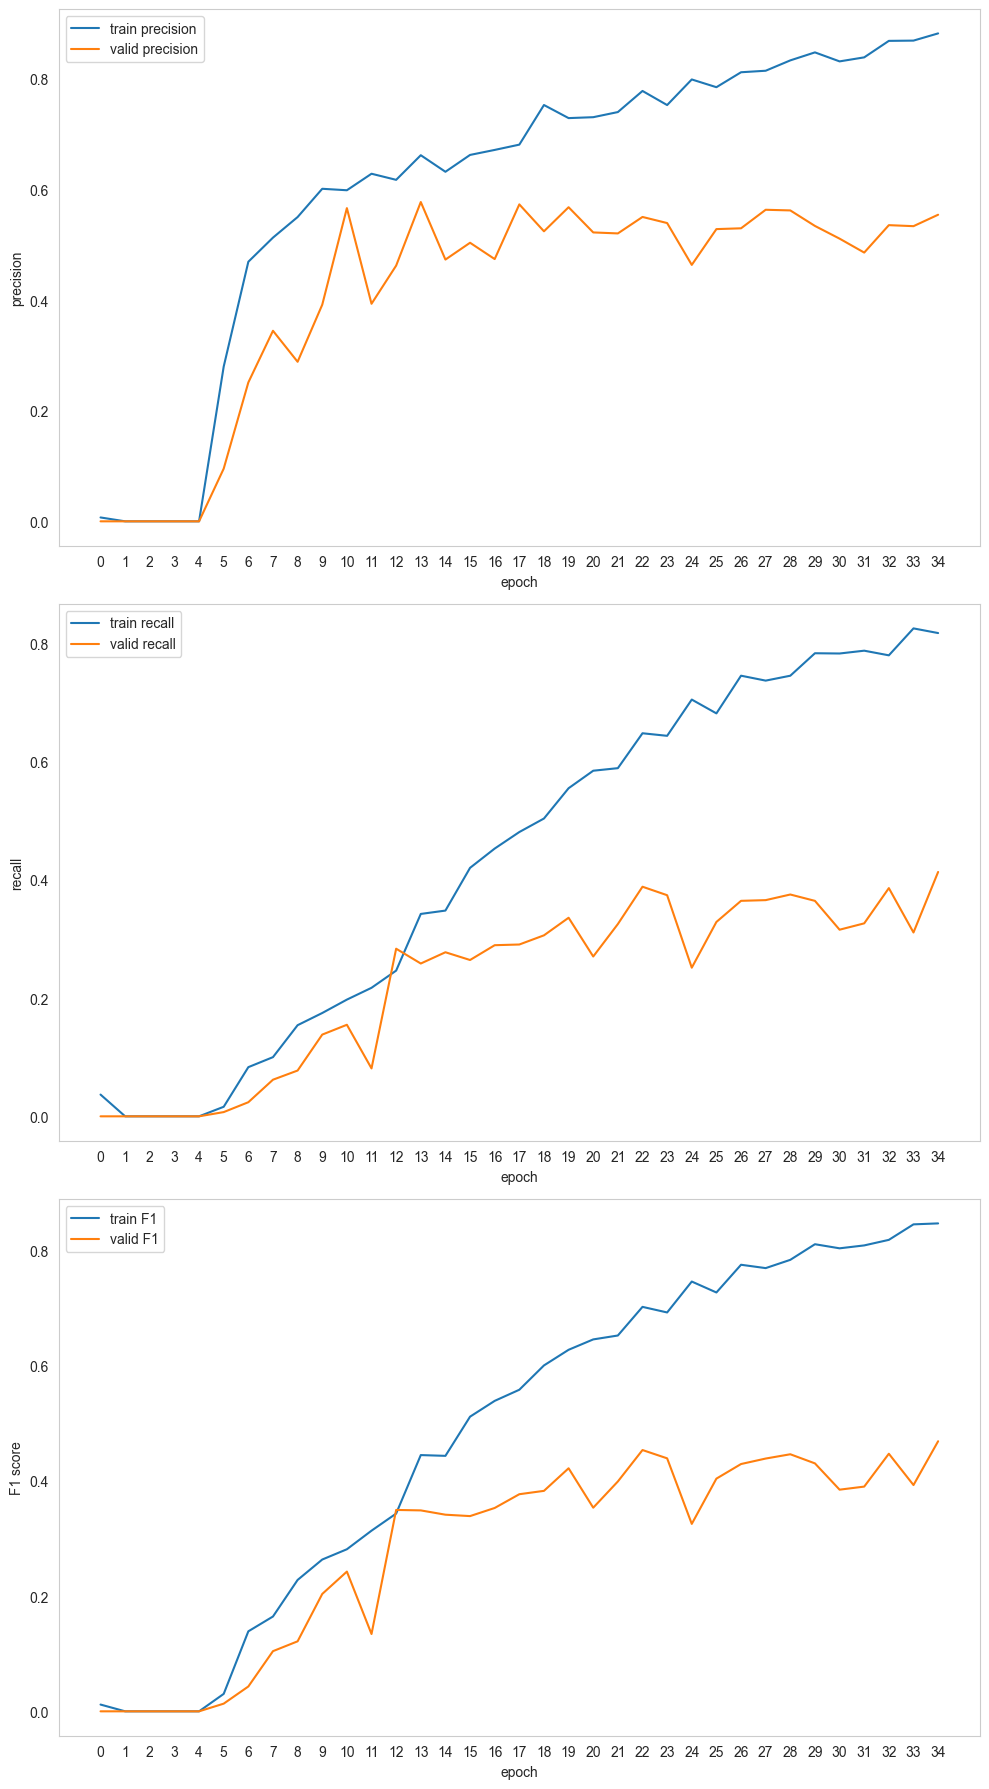

In [58]:
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

axes[0].plot(metrics["train_precisions"], label="train precision")
axes[0].plot(metrics["valid_precisions"], label="valid precision")
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("precision")
axes[0].set_xticks(range(n_epochs))
axes[0].legend()
axes[0].grid()

axes[1].plot(metrics["train_recalls"], label="train recall")
axes[1].plot(metrics["valid_recalls"], label="valid recall")
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("recall")
axes[1].set_xticks(range(n_epochs))
axes[1].legend()
axes[1].grid()

axes[2].plot(metrics["train_f1s"], label="train F1")
axes[2].plot(metrics["valid_f1s"], label="valid F1")
axes[2].set_xlabel("epoch")
axes[2].set_ylabel("F1 score")
axes[2].set_xticks(range(n_epochs))
axes[2].legend()
axes[2].grid()

plt.tight_layout()
plt.show()

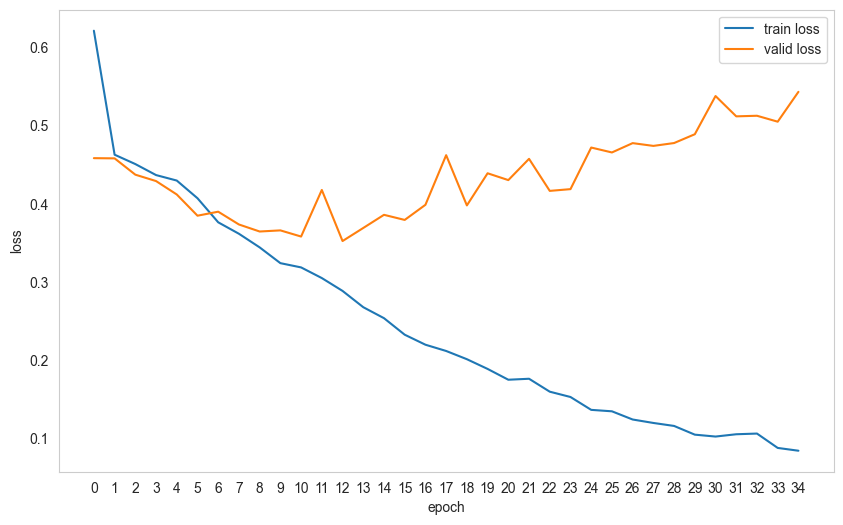

In [63]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

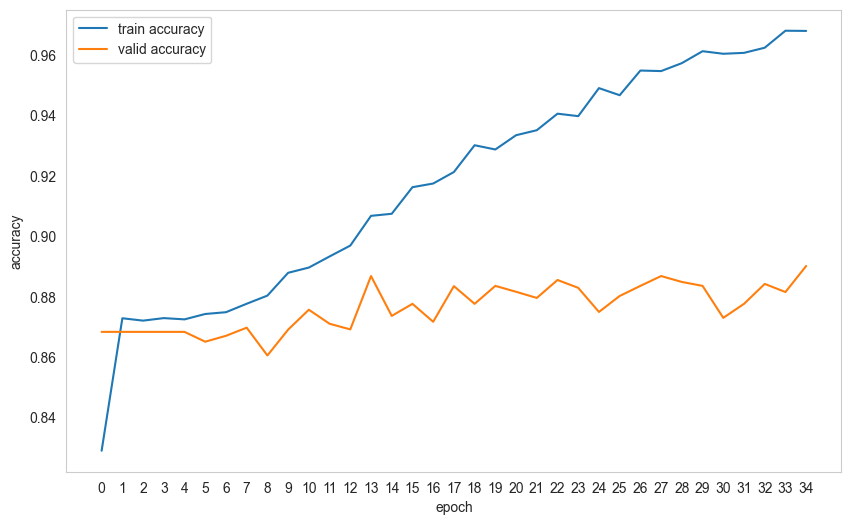

In [64]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

evaluating...: 100%|██████████| 3/3 [00:00<00:00, 11.60it/s]


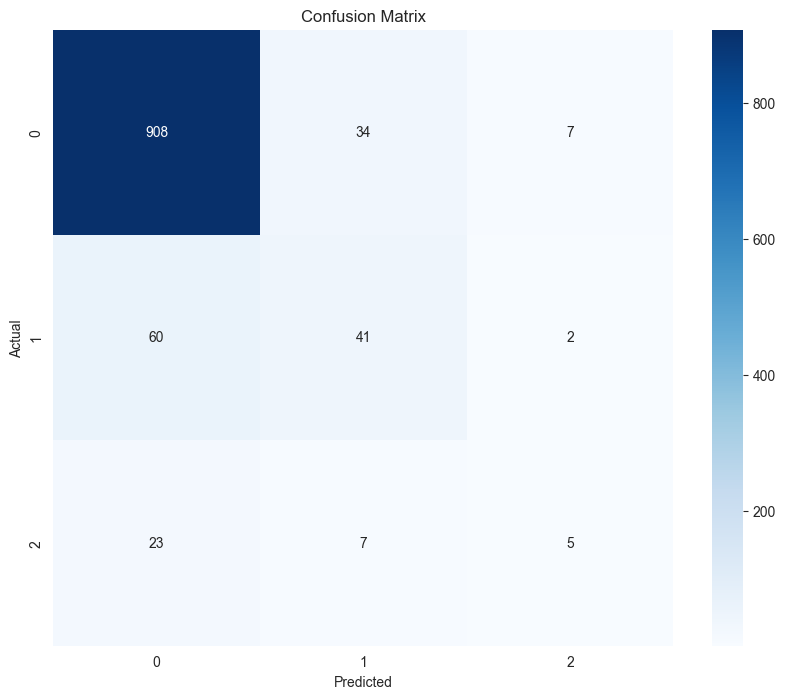

In [65]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def compute_confusion_matrix(predictions, labels):
    predicted_classes = predictions.argmax(dim=-1).cpu().numpy()
    true_classes = labels.cpu().numpy()
    return confusion_matrix(true_classes, predicted_classes)

def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    epoch_precisions = []
    epoch_recalls = []
    epoch_f1s = []
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            label = batch["label"].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            precision = get_precision(prediction, label)
            recall = get_recall(prediction, label)
            f1 = get_f1(precision, recall)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
            epoch_precisions.append(precision)
            epoch_recalls.append(recall)
            epoch_f1s.append(f1)
            all_predictions.append(prediction)
            all_labels.append(label)
    all_predictions = torch.cat(all_predictions)
    all_labels = torch.cat(all_labels)
    conf_matrix = compute_confusion_matrix(all_predictions, all_labels)
    return np.mean(epoch_losses), np.mean(epoch_accs), np.mean(epoch_precisions), np.mean(epoch_recalls), np.mean(epoch_f1s), conf_matrix

# Evaluate the model and get the confusion matrix
valid_loss, valid_acc, valid_precision, valid_recall, valid_f1, conf_matrix = evaluate(valid_data_loader, model, criterion, device)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()